In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from astropy.timeseries import LombScargle
import astropy.units as u

from tqdm import tqdm
# from astropy import table as tbl

In [2]:
tqdm.pandas()

# Load/Create Catalogs

First we will load/create our quasar catalogs, including paths to lightcurve files for each one. For the CRTS sample we need to "make" this catalog manually, in the sense that we have to populate out light curve files (for now we only have two lightcurves, but hopefully later we will have more). We will also load a catalog spectroscopically confirmed QSOs with light curves in the SDSS DR7 stripe 82 (MacLeod+ 2011, http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html).

## CRTS Sample

In [3]:
with open('./data/crts_catalog.txt') as f:
    crts_catalog = pd.read_csv(f, sep='\s+', header=0)
    
crts_catalog['lightcurve'] = './data/lightcurves/CRTS/' + crts_catalog['dbId'].astype(str)
crts_catalog['fap'] = 1.
crts_catalog['f_orbit'] = 0
crts_catalog['f_gw'] = 2 * crts_catalog['f_orbit']
crts_catalog['t_obs'] = 0
crts_catalog

,dbId,RA,Dec,Redshift,BH_mass,lightcurve,fap,f_orbit,f_gw,t_obs
0,2,5.763333,1.259417,0.729,9.19,./data/lightcurves/CRTS/2,1.0,0,0,0
1,3,25.958333,14.248583,1.438,9.21,./data/lightcurves/CRTS/3,1.0,0,0,0
2,6,42.370417,1.156944,0.954,8.95,./data/lightcurves/CRTS/6,1.0,0,0,0
3,8,62.945417,13.404583,0.277,8.16,./data/lightcurves/CRTS/8,1.0,0,0,0
4,10,68.860417,-16.729361,0.098,7.78,./data/lightcurves/CRTS/10,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
93,102,256.567500,37.157500,1.267,9.10,./data/lightcurves/CRTS/102,1.0,0,0,0
94,104,260.976250,37.811583,0.828,9.38,./data/lightcurves/CRTS/104,1.0,0,0,0
95,105,261.737083,60.063639,0.991,9.15,./data/lightcurves/CRTS/105,1.0,0,0,0
96,108,332.570833,12.370556,0.717,9.00,./data/lightcurves/CRTS/108,1.0,0,0,0


In [4]:
# with open('./data/Graham2015.tsv') as f:
#     crts_candidates = pd.read_csv(f, sep='\t', header=0, skiprows=[1, 2]) #, usecols=[0, 1, 2, 3, 4, 5, 6])

# crts_candidates['logMBH'] = pd.to_numeric(crts_candidates['logMBH'], errors='coerce')

# crts_candidates = crts_candidates.rename(columns={"logMBH": "log_mbh",
#                                                   # "Vmed": "v_app",
#                                                   "RAJ2000":"ra",
#                                                   "DEJ2000": "dec",
#                                                   "z": "redshift",
#                                                   "Name": "dbID"})
# crts_candidates = crts_candidates[['dbID', 'redshift', 'log_mbh', 'ra', 'dec']]
# crts_candidates['lightcurve'] = './data/lightcurves/CRTS/' + crts_candidates['dbID'].astype(str)
# crts_candidates['binary'] = False
# crts_candidates

In [5]:
# qso_SBS0920 = pd.read_csv('./data/lightcurves/CRTS/SBS0920.csv')
# qso_SBS0920

In [6]:
# qso_J1139 = pd.read_csv('./data/lightcurves/CRTS/J1139.csv')
# qso_J1139

## SDSS DR7 Stripe 82

First we'll load the stripe 82 sample. It doesn't really matter what order we load our catalogs in, and (asssuming we get more CRTS data) we'll use the CRTS catalog to calibrate. However we'd like the CRTS catalog format to match the SDSS catalog format, so we'll load the SDSS catalog first so we can use it as a reference.

In [7]:
with open('./data/sdss_catalog.txt') as f:
    sdss_catalog = pd.read_csv(f, sep='\s+', header=0)
    
sdss_catalog['lightcurve'] = './data/lightcurves/SDSS/' + sdss_catalog['dbId'].astype(str)
sdss_catalog['fap'] = 1.
sdss_catalog['f_orbit'] = 0
sdss_catalog['f_gw'] = 2 * sdss_catalog['f_orbit']
sdss_catalog['t_obs'] = 0
sdss_catalog

,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs
0,70,2.16931,1.23865,1.0737,7.52,1.52,./data/lightcurves/SDSS/70,1.0,0,0,0
1,98,1.09103,0.96212,0.7929,8.82,0.17,./data/lightcurves/SDSS/98,1.0,0,0,0
2,233,0.33129,0.17723,1.6209,8.92,0.20,./data/lightcurves/SDSS/233,1.0,0,0,0
3,1018,1.36470,-0.09896,0.6124,9.02,0.27,./data/lightcurves/SDSS/1018,1.0,0,0,0
4,1310,0.22156,-0.29249,2.7571,9.25,0.06,./data/lightcurves/SDSS/1310,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9249,2004174,35.94376,1.25743,2.4168,8.26,0.17,./data/lightcurves/SDSS/2004174,1.0,0,0,0
9250,2020108,35.95967,1.24256,1.8007,8.45,0.51,./data/lightcurves/SDSS/2020108,1.0,0,0,0
9251,2474692,44.04546,1.22344,0.9871,8.02,0.33,./data/lightcurves/SDSS/2474692,1.0,0,0,0
9252,4952501,55.36400,1.25396,3.1043,9.18,0.20,./data/lightcurves/SDSS/4952501,1.0,0,0,0


# Initial data exploration

Here we take an initial look at the light curves for the quasars we're exploring.

In [8]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
context = 'talk'
sns.set_context(context)
sns.set_style('ticks')
sns.set_palette('colorblind')
rcparams = {'font.family': 'DejaVu Sans',
            'font.serif': 'Times',
            'lines.markersize': np.sqrt(10),
            'text.latex.preamble': r'\\usepackage{amsmath}',
            'text.usetex': False,
            # 'hatch.linewidth' : 3.0,
            'figure.figsize': (12.8, 9.6),
            'xtick.direction': 'in',
            'xtick.top': True,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'ytick.right': True,
            'ytick.direction': 'in'}
plt.rcParams.update(rcparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
def plot_lightcurve(t, mag, magerr):
    ax = plt.gca()
    ax.errorbar(t, mag, yerr=magerr,
                marker='o', linestyle='none')
    
    med = np.median(mag)
    ylow, yhigh = med - 1, med + 1
    ax.set_ylim(ylow, yhigh)
    
    ax.set_xlabel('MJD')
    ax.set_ylabel('Mag')
    # plt.show()
    
    return ax

## Plot CRTS light curves

First we'll plot the first 10 CRTS light curves.

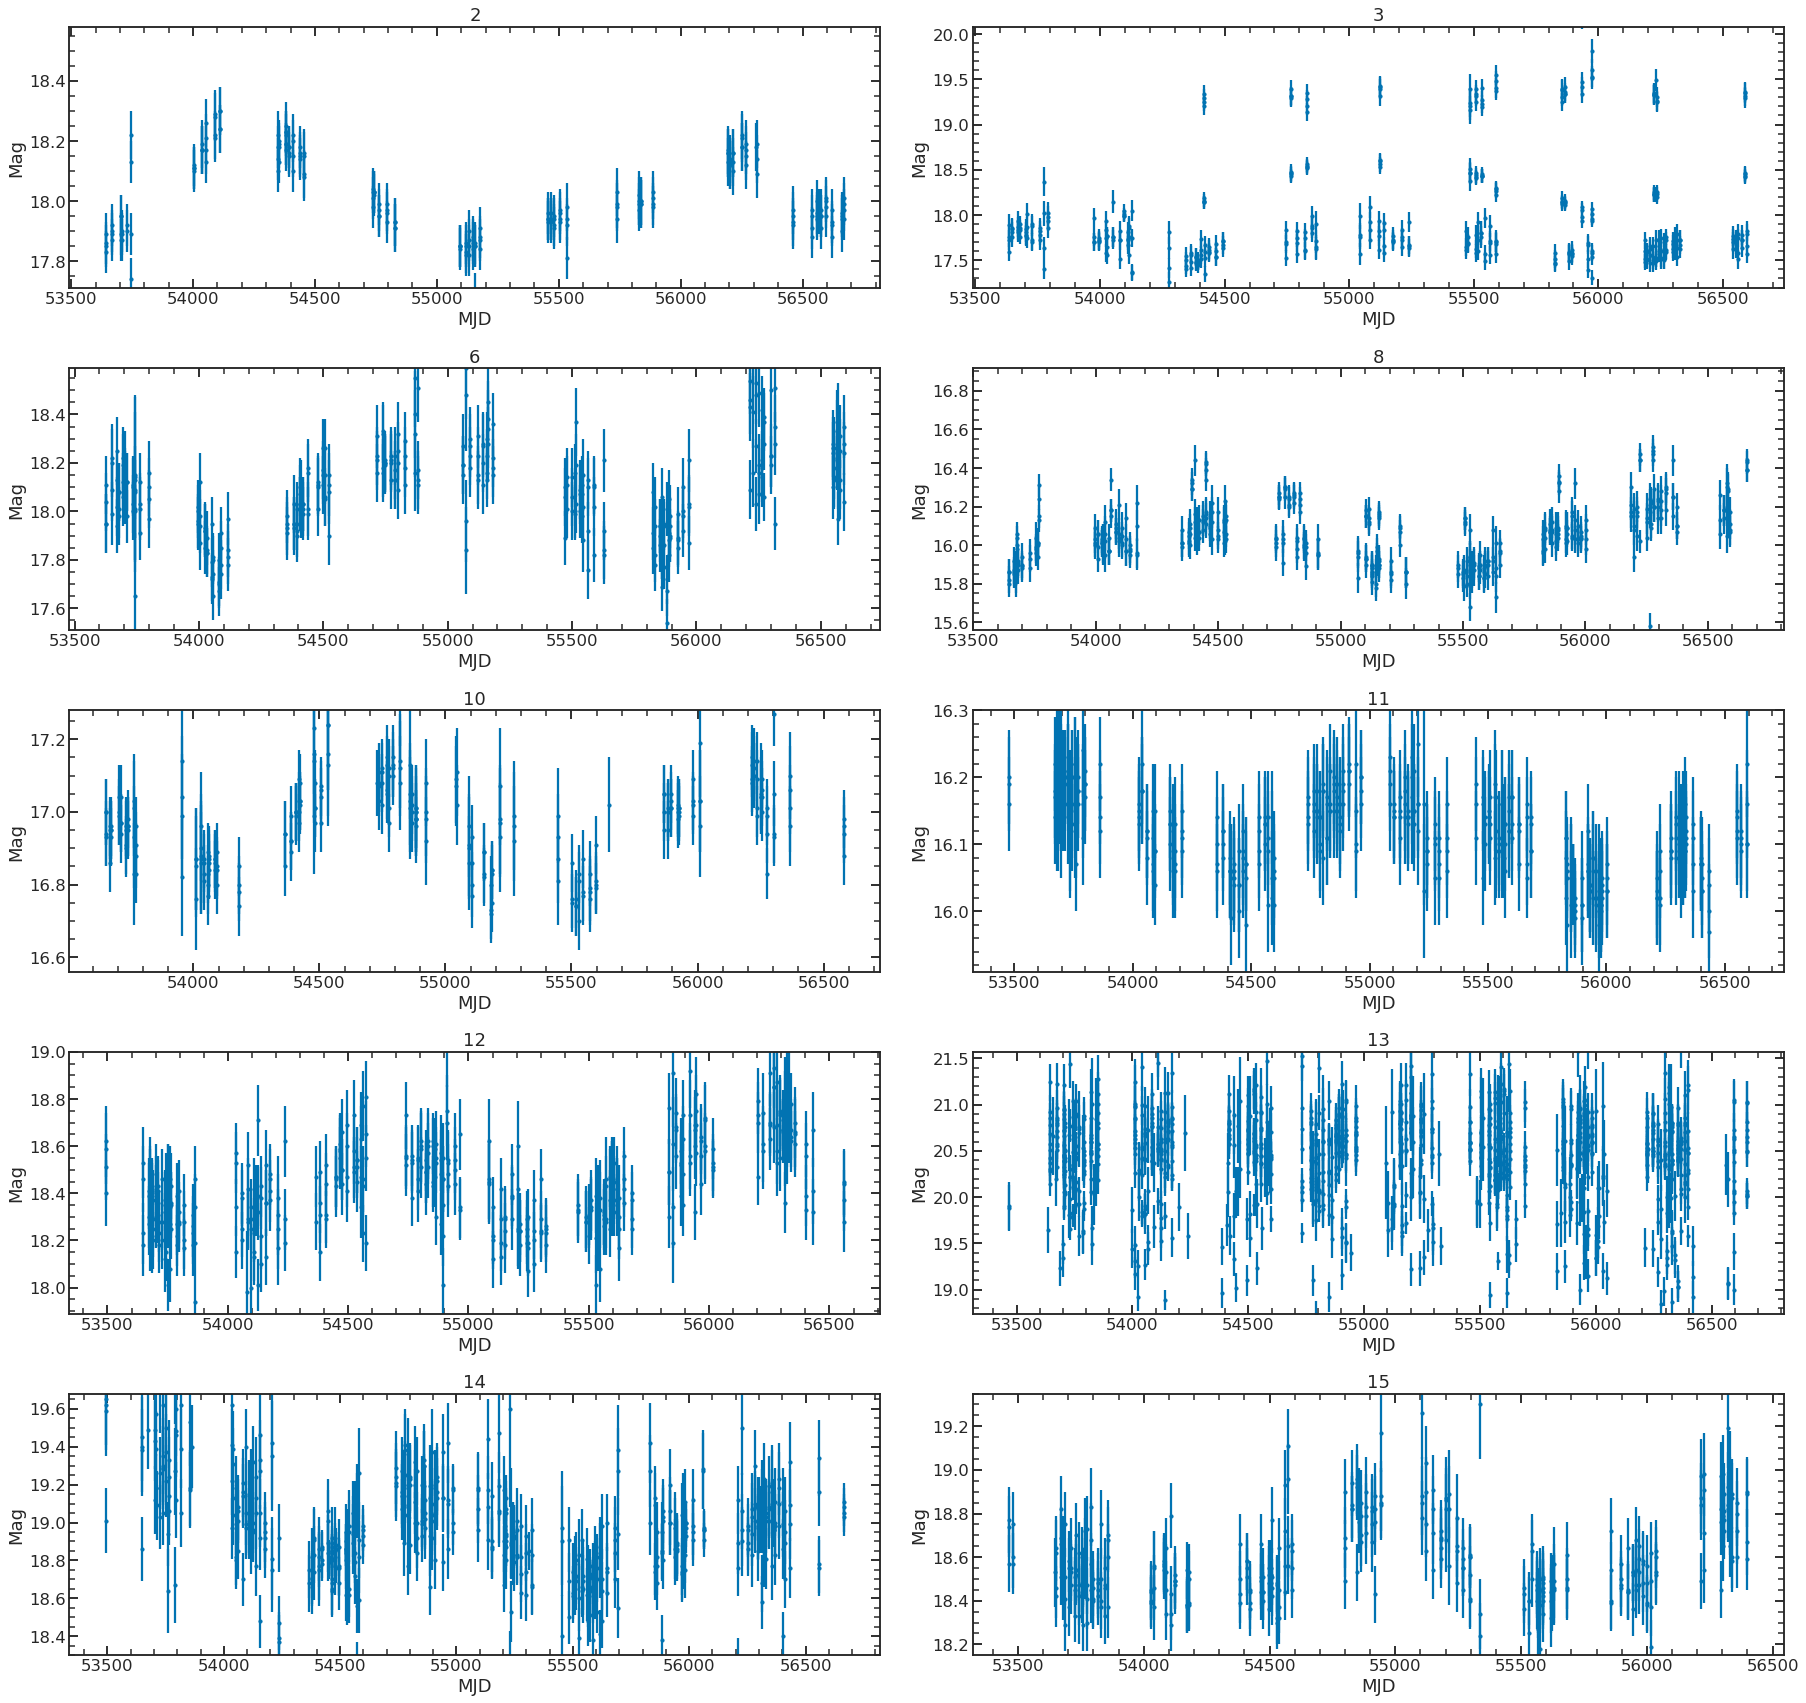

In [10]:
n_plots = 10
n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))
# lc_cols = ['MJD_u', 'u', 'u_err',
#            'MJD_g', 'g', 'g_err',
#            'MJD_r', 'r', 'r_err',
#            'MJD_i', 'i', 'i_err',
#            'MJD_z', 'z', 'z_err',
#            'ra_median', 'decl_median']

fig, ax = plt.subplots(n_rows, n_cols, figsize=(6.4 * 4, 9.6 / 2 * n_rows))
# fig = plt.figure()
# gs = fig.add_gridspec(int(np.ceil(n_plots / 2)), 2)

for i, a in enumerate(ax.flatten()):
    filepath = crts_catalog['lightcurve'][i]
    with open(filepath) as f:
        lc = pd.read_csv(f, sep=',', header=0)
    
    a.errorbar(lc['MJD'], lc['Mag'], yerr=lc['MagErr'],
                marker='o', linestyle='none')
    
    med = np.median(lc['Mag'])
    ylow = med - 3 * np.diff(np.quantile(lc['Mag'], q=[.16, .5]))
    yhigh = med + 3 * np.diff(np.quantile(lc['Mag'], q=[.5, .84]))
    # ylow, yhigh = lc['Mag'].min() - .5, lc['Mag'].max() + .5
    a.set_ylim(ylow, yhigh)
    
    a.set_xlabel('MJD')
    a.set_ylabel('Mag')
    a.set_title(crts_catalog['dbId'][i])
    
    # a = plot_lightcurve(lc['MJD_u'], lc['u'], lc['u_err'])
    # fig.add_subplot(ax)

plt.tight_layout()
plt.savefig('./figures/crts_lightcurves.pdf')
plt.savefig('./figures/crts_lightcurves.png')
plt.show()

## Plot SDSS light curves

First we'll plot some random SDSS light curves.

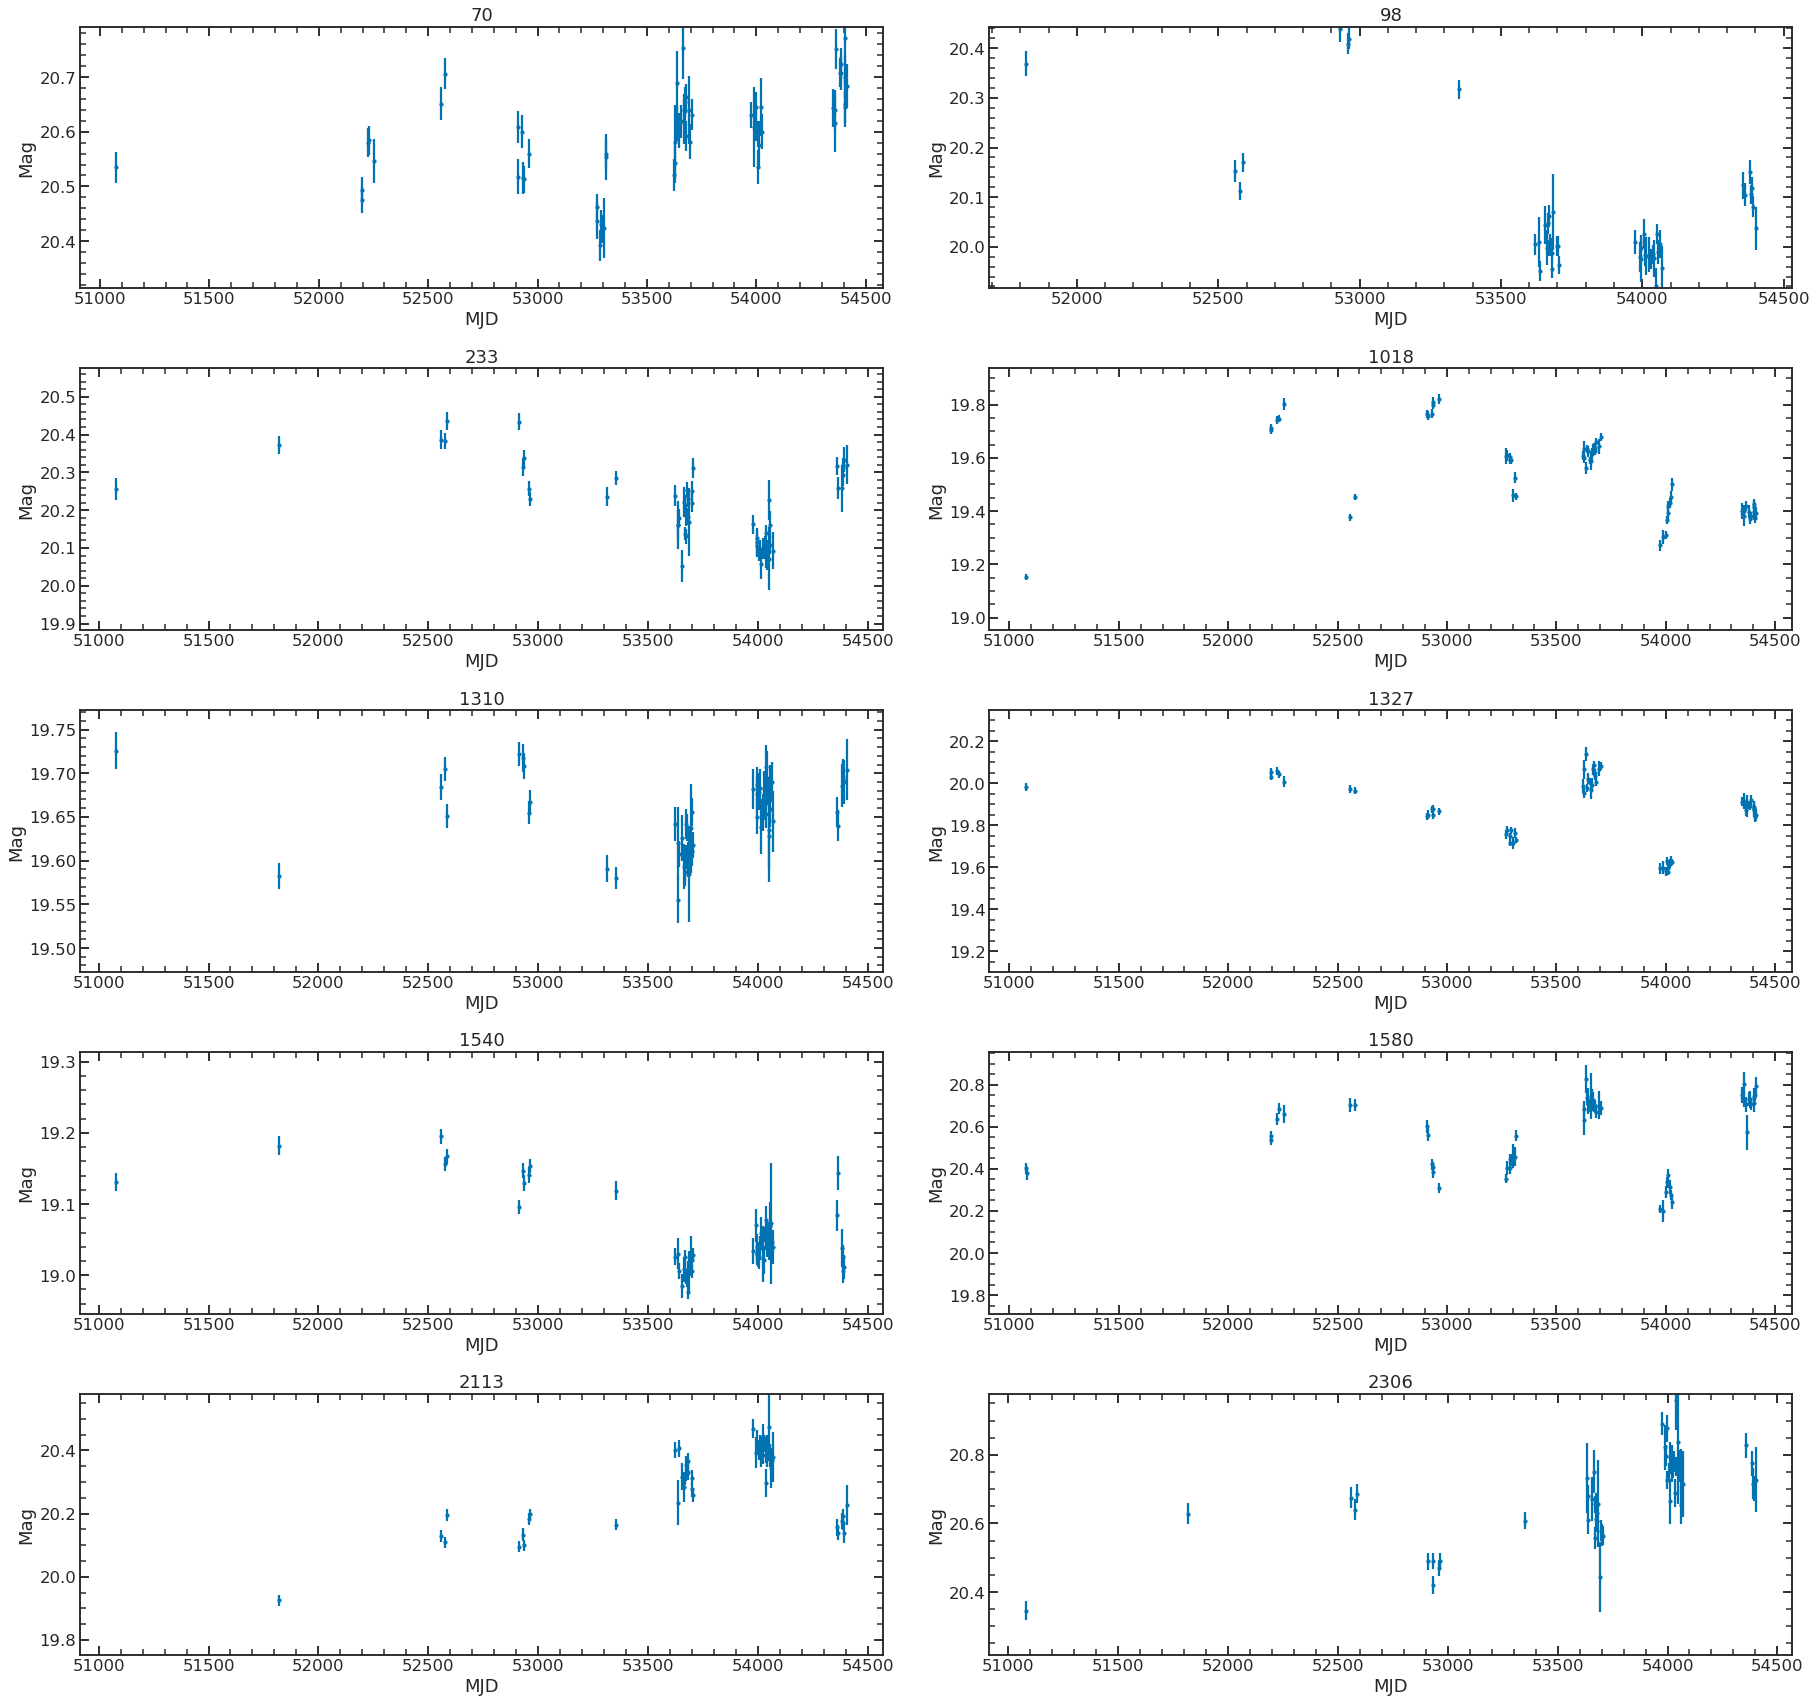

In [11]:
n_plots = 10
n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))
lc_cols = ['MJD_u', 'u', 'u_err',
           'MJD_g', 'g', 'g_err',
           'MJD_r', 'r', 'r_err',
           'MJD_i', 'i', 'i_err',
           'MJD_z', 'z', 'z_err',
           'ra_median', 'decl_median']

fig, ax = plt.subplots(n_rows, n_cols, figsize=(6.4 * 4, 9.6 / 2 * n_rows))
# fig = plt.figure()
# gs = fig.add_gridspec(int(np.ceil(n_plots / 2)), 2)

for i, a in enumerate(ax.flatten()):
    filepath = sdss_catalog['lightcurve'][i]
    with open(filepath) as f:
        lc = pd.read_csv(f, names=lc_cols, sep='\s+')
    
    a.errorbar(lc['MJD_g'], lc['g'], yerr=lc['g_err'],
                marker='o', linestyle='none')
    
    med = np.median(lc['g'])
    ylow = med - 3 * np.diff(np.quantile(lc['g'], q=[.16, .5]))
    yhigh = med + 3 * np.diff(np.quantile(lc['g'], q=[.5, .84]))
    a.set_ylim(ylow, yhigh)
    
    a.set_xlabel('MJD')
    a.set_ylabel('Mag')
    a.set_title(sdss_catalog['dbId'][i])
    
    # a = plot_lightcurve(lc['MJD_u'], lc['u'], lc['u_err'])
    # fig.add_subplot(ax)

plt.tight_layout()
plt.savefig('./figures/sdss_lightcurves.pdf')
plt.savefig('./figures/sdss_lightcurves.png')
plt.show()

# Lomb-Scargle

First we'll use Lomb-Scargle to explore our data. This will give us a good idea of what the power spectral density of the light curves are. This also will give us a starting point for the MCMC parameter fitting we'll do later.

In [12]:
def plot_psd(ls):
    frequency, power = ls.autopower()
    
    plt.figure()
    plt.plot(frequency, power)
    plt.xlabel('Frequency')
    plt.ylabel('Power')

    plt.xscale('log')
    plt.show()
    
    
def plot_model(ls):
    """Plots the best-fit Lomb-Scargle model for a quasar lightcurve.
    
    Parameters
    ----------
    ls : LombScargle
        astropy Lomb-Scargle object
    time : array_like of float
        The time of the data observations in seconds
    mag : array_like of float
        The magnitude of the data observations
    
    """
    time, mag, magerr = ls.t, ls.y, ls.dy
    time_mjd = time.to(u.day)
    frequency, power = ls.autopower()
    
    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(time.min(), time.max())
    y_fit = ls.model(t_fit, best_frequency)
    
    plt.figure()
    plt.errorbar(time_mjd, mag, yerr=magerr,
                 marker='o', linestyle='none')
    plt.plot(t_fit.to(u.day), y_fit)
    plt.xlabel('MJD')
    plt.ylabel('Mag')
    plt.show()

## Detection confidence

We'll use the false alarm probability to thereshold whether or not we have a periodic signal.

In [13]:
def detection_probability(ls):
    frequency, power = ls.autopower()
    return ls.false_alarm_probability(power.max())

### Null test

Let's test this to make sure we don't pick up something that we know is just white noise

In [14]:
# qso_SBS0920_mag_test = qso_SBS0920_mag.mean() + 1e-1 * np.random.randn(len(qso_SBS0920_mag)) * u.mag
# ls_test = LombScargle(qso_SBS0920_mjd, qso_SBS0920_mag_test, qso_SBS0920_magerr)

# plot_psd(ls_test)

# plot_model(ls_test)

In [15]:
# print(detection_probability(ls_test))

## Periodicity search

Now we'll perform a search for periodicity in our sources.

In [19]:
def qso_fap(qso, crts=False):
    lc_cols = ['MJD_u', 'u', 'u_err',
               'MJD_g', 'g', 'g_err',
               'MJD_r', 'r', 'r_err',
               'MJD_i', 'i', 'i_err',
               'MJD_z', 'z', 'z_err',
               'ra_median', 'decl_median']
    
    filepath = qso['lightcurve']
    with open(filepath) as f:  # read in the lighcurve
        if crts:
            lc = pd.read_csv(f, sep=',', header=0)
        else:
            lc = pd.read_csv(f, names=lc_cols, sep='\s+')
            lc = lc.rename(columns={"MJD_g": "MJD",
                                    "g": "Mag",
                                    "g_err": "MagErr"})
            lc = lc[['MJD', 'Mag', 'MagErr']]
#         except:
            
#             print(lc)
    
    # lc = pd.read_csv(qso['lightcurve'])  # read in the lightcurve
        
    mjd = (lc['MJD'].values * u.day).to(u.s)  # convert MJD to sec
    mag = lc['Mag'].values * u.mag  # for now we'll only search over visual magnitudes
    magerr = lc['MagErr'].values * u.mag
    
    t_obs = (np.max(mjd) - np.min(mjd)).value

    ls = LombScargle(mjd, mag, magerr)

    # calculate the frequency and significance
    try:
        frequency, power = ls.autopower()
    except ValueError as e:
    #     print(":(")
        print(filepath)
        print(lc)
        raise e
    best_frequency = frequency[np.argmax(power)].value  # Hz
    # p_det = ls.false_alarm_probability(power.max(), method='bootstrap')
    p_det = ls.false_alarm_probability(power.max(), method='baluev')
    return pd.Series([t_obs, best_frequency, 2 * best_frequency, p_det])
    


def periodic_lightcurve_search(catalog, crts=False):
    """Perform a search for periodic lightcurves.
    
    """
    catalog[['t_obs', 'f_orbit', 'f_gw', 'fap']] = catalog.progress_apply(qso_fap, axis=1, args=(crts,))
    return catalog

### CRTS

In [23]:
crts_catalog = periodic_lightcurve_search(crts_catalog, crts=True)
crts_catalog['t_per'] = 1 / crts_catalog['f_orbit']
crts_catalog['n_per'] = crts_catalog['t_obs'] / crts_catalog['t_per']
crts_catalog

100%|██████████████████████████████████████████| 98/98 [00:00<00:00, 129.17it/s]


,dbId,RA,Dec,Redshift,BH_mass,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
0,2,5.763333,1.259417,0.729,9.19,./data/lightcurves/CRTS/2,6.793212222822695e-63,6.506727e-09,1.301345e-08,2.612681e+08,1.536871e+08,1.7
1,3,25.958333,14.248583,1.438,9.21,./data/lightcurves/CRTS/3,4.2765368363461865e-23,2.571892e-06,5.143784e-06,2.556484e+08,3.888188e+05,657.5
2,6,42.370417,1.156944,0.954,8.95,./data/lightcurves/CRTS/6,3.1706890784569603e-52,7.419663e-09,1.483933e-08,2.560763e+08,1.347770e+08,1.9
3,8,62.945417,13.404583,0.277,8.16,./data/lightcurves/CRTS/8,3.09496786377524e-05,4.128953e-06,8.257907e-06,2.600417e+08,2.421921e+05,1073.7
4,10,68.860417,-16.729361,0.098,7.78,./data/lightcurves/CRTS/10,1.481839167748785e-56,8.309435e-09,1.661887e-08,2.527248e+08,1.203451e+08,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...
93,102,256.567500,37.157500,1.267,9.10,./data/lightcurves/CRTS/102,5.898469889618759e-31,7.938572e-09,1.587714e-08,2.645312e+08,1.259672e+08,2.1
94,104,260.976250,37.811583,0.828,9.38,./data/lightcurves/CRTS/104,1.2288784447830799e-78,5.655629e-09,1.131126e-08,2.652225e+08,1.768150e+08,1.5
95,105,261.737083,60.063639,0.991,9.15,./data/lightcurves/CRTS/105,8.524825563946667e-11,6.390423e-09,1.278085e-08,2.347262e+08,1.564842e+08,1.5
96,108,332.570833,12.370556,0.717,9.00,./data/lightcurves/CRTS/108,2.612521169273309e-11,8.711435e-09,1.742287e-08,2.640208e+08,1.147917e+08,2.3


### SDSS

In [24]:
sdss_catalog = periodic_lightcurve_search(sdss_catalog)
sdss_catalog['t_per'] = 1 / sdss_catalog['f_orbit']
sdss_catalog['n_per'] = sdss_catalog['t_obs'] / sdss_catalog['t_per']
sdss_catalog

100%|██████████████████████████████████████| 9254/9254 [00:50<00:00, 183.64it/s]


,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
0,70,2.16931,1.23865,1.0737,7.52,1.52,./data/lightcurves/SDSS/70,0.9999998762219728,4.720596e-07,9.441193e-07,2.883110e+08,2.118376e+06,136.1
1,98,1.09103,0.96212,0.7929,8.82,0.17,./data/lightcurves/SDSS/98,4.720291989774648e-16,6.721394e-09,1.344279e-08,2.231680e+08,1.487787e+08,1.5
2,233,0.33129,0.17723,1.6209,8.92,0.20,./data/lightcurves/SDSS/233,1.0,3.753433e-07,7.506866e-07,2.869373e+08,2.664228e+06,107.7
3,1018,1.36470,-0.09896,0.6124,9.02,0.27,./data/lightcurves/SDSS/1018,0.9999999999991114,4.290505e-07,8.581010e-07,2.883110e+08,2.330728e+06,123.7
4,1310,0.22156,-0.29249,2.7571,9.25,0.06,./data/lightcurves/SDSS/1310,1.0,4.541061e-07,9.082123e-07,2.869373e+08,2.202128e+06,130.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9249,2004174,35.94376,1.25743,2.4168,8.26,0.17,./data/lightcurves/SDSS/2004174,1.0,3.589848e-07,7.179697e-07,2.883130e+08,2.785633e+06,103.5
9250,2020108,35.95967,1.24256,1.8007,8.45,0.51,./data/lightcurves/SDSS/2020108,1.0,3.589848e-07,7.179697e-07,2.883130e+08,2.785633e+06,103.5
9251,2474692,44.04546,1.22344,0.9871,8.02,0.33,./data/lightcurves/SDSS/2474692,0.9997786298130309,9.538244e-08,1.907649e-07,2.883130e+08,1.048411e+07,27.5
9252,4952501,55.36400,1.25396,3.1043,9.18,0.20,./data/lightcurves/SDSS/4952501,0.9999999999999967,4.228044e-07,8.456087e-07,2.883130e+08,2.365160e+06,121.9


### Apply population cuts

Next we'll start cutting this catalog down to our actual candidates by applying the following the following requirements:
 * False alarm probability (FAP): $P(D | M_{\rm noise}) < 0.003$ (i.e. $\sim 3 \sigma$ upper limit).
   * This is the probability of obserrving data $D$ given a noise-only model $M_{\rm noise}$
   * It is worth noting that this is really just a proxy for $P(M_{\rm noise} | D)$. In actuality, $P(M_{\rm noise} | D) = \frac{P(D | M_{\rm noise}) P(M_{\rm noise})}{P(D)}$
   * A better statistic to calculate would be $P(M_{\rm periodic} | D) = \frac{P(D | M_{\rm periodic}) P(M_{\rm periodic})}{P(D)}$
 * Observed periods: $N_{\rm obs} \geq 1.5$.

In [33]:
crts_catalog['fap'].max()

<Quantity 0.00058335>

In [31]:
1 - 0.997300203936740

0.002699796063259985

In [32]:
fap_cut = sdss_catalog['fap'] < crts_catalog['fap'].max()
n_per_cut = sdss_catalog['n_per'] >= 1.5

candidate_catalog = sdss_catalog[fap_cut & n_per_cut]
candidate_catalog

,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
21,5036,4.72605,-1.03396,1.9279,9.56,0.19,./data/lightcurves/SDSS/5036,7.227860927928438e-12,1.907662e-08,3.815324e-08,2.883110e+08,5.242019e+07,5.5
48,14323,1.82426,-0.86049,0.5259,8.50,0.34,./data/lightcurves/SDSS/14323,9.641819093660319e-07,4.335595e-08,8.671191e-08,2.883110e+08,2.306488e+07,12.5
63,20511,1.01584,-0.68812,1.9680,8.50,0.65,./data/lightcurves/SDSS/20511,1.5282656762222957e-07,2.125900e-08,4.251800e-08,2.869373e+08,4.703891e+07,6.1
89,26043,3.95108,0.14088,1.7196,8.37,0.49,./data/lightcurves/SDSS/26043,5.223331429320026e-14,4.426054e-08,8.852107e-08,2.869373e+08,2.259349e+07,12.7
137,42942,0.22122,-0.62024,1.3208,9.16,0.07,./data/lightcurves/SDSS/42942,1.8643528300874475e-07,7.991826e-09,1.598365e-08,2.877940e+08,1.251278e+08,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9217,4971760,56.30490,0.93455,2.2344,8.35,0.48,./data/lightcurves/SDSS/4971760,3.119189425447875e-05,8.468748e-08,1.693750e-07,2.869373e+08,1.180812e+07,24.3
9219,3453144,313.51358,0.82452,0.9093,8.74,0.09,./data/lightcurves/SDSS/3453144,9.785900045285812e-19,4.105668e-08,8.211336e-08,2.021596e+08,2.435657e+07,8.3
9235,3065793,45.73933,1.02758,1.2198,8.33,0.19,./data/lightcurves/SDSS/3065793,5.776561810197289e-22,7.318671e-09,1.463734e-08,2.869373e+08,1.366368e+08,2.1
9236,3048059,46.08585,1.07453,1.1313,8.39,0.29,./data/lightcurves/SDSS/3048059,1.7837467685650234e-28,5.202679e-09,1.040536e-08,2.883130e+08,1.922087e+08,1.5


#### Plot the best

Next we'll plot the 10 best candidates we have.

# Strain calculation

Finally we'll calculate strain for all of these candidates.

# Uncertainty Estimation

The Lomb-Scargle method doesn't give us actual uncertainties on the parameteers, so we'll try a few methods to estimate those

## Markov Chain Monte Carlo

Next we'll use MCMC to get a handle on our model uncertainties.

In [27]:
# def periodic_model(t, log_f, th0, th1, th2):
#     f = 10 ** log_f
#     sin_term = th1 * np.sin(2 * np.pi * f * t)
#     cos_term = th2 * np.cos(2 * np.pi * f * t)
    
#     return th0 + sin_term + cos_term

In [28]:
# theta_init = np.array([np.log10(best_frequency.value)])
# model_params = ls.model_parameters(best_frequency)
# theta_init = np.append(theta_init, model_params.value)
# theta_init[1] += ls.offset().value  # accounts for the missing offset component from centering data (dumb)

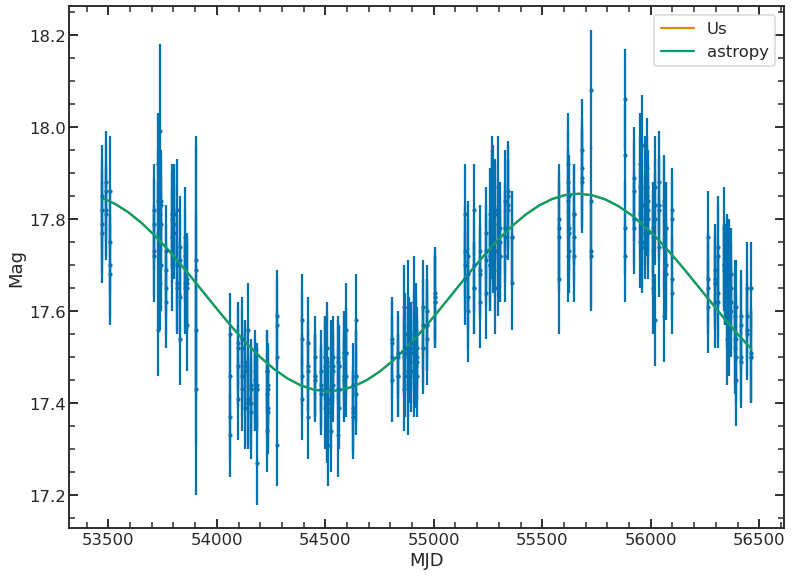

In [29]:
# plt.figure()
# plt.errorbar(qso_J1139['MJD'], qso_J1139['Mag'], yerr=qso_J1139['Magerr'],
#             marker='o', linestyle='none')
# plt.plot(t_fit.to(u.day), periodic_model(t_fit.value, *theta_init), label="Us")
# plt.plot(t_fit.to(u.day), y_fit, label="astropy")
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.show()

In [82]:
# # define our MCMC likelihoods
# def log_likelihood(theta, t, mag, magerr):
#     log_f, th0, th1, th2 = theta
#     model = periodic_model(t, log_f, th0, th1, th2)
#     sigma2 = magerr ** 2
#     return -0.5 * np.sum((mag - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))


# def log_prior(theta):
#     log_f, th0, th1, th2 = theta
#     if -10 < log_f < -5 and 13 < th0 < 22 and -3 <= th1 <= 3 and 0 <= th2 <= 3:
#         return 0.0
#     return -np.inf


# def log_probability(theta, t, mag, magerr):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, t, mag, magerr)

In [83]:
# # define our MCMC likelihoods
# def log_likelihood(theta, t, mag, magerr, th1, th2):
#     log_f, th0 = theta
#     model = periodic_model(t, log_f, th0, th1, th2)
#     sigma2 = magerr ** 2
#     return -0.5 * np.sum((mag - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))


# def log_prior(theta):
#     log_f, th0 = theta
#     if -10 < log_f < -5 and 13 < th0 < 22:
#         return 0.0
#     return -np.inf


# def log_probability(theta, t, mag, magerr, th1, th2):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, t, mag, magerr, th1, th2)

In [84]:
# import emcee

# nwalkers = 32
# ndim = 4
# pos = theta_init + 1e-4 * np.random.randn(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(qso_J1139_mjd.value,
#                                            qso_J1139_mag.value,
#                                            qso_J1139_magerr.value)
# )
# sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████| 5000/5000 [00:07<00:00, 673.85it/s]


In [85]:
# import emcee

# nwalkers = 32
# ndim = 2
# pos = theta_init[:2] + 1e-4 * np.random.randn(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(qso_J1139_mjd.value,
#                                            qso_J1139_mag.value,
#                                            qso_J1139_magerr.value,
#                                            theta_init[2],
#                                            theta_init[3])
# )
# sampler.run_mcmc(pos, 5000, progress=True);

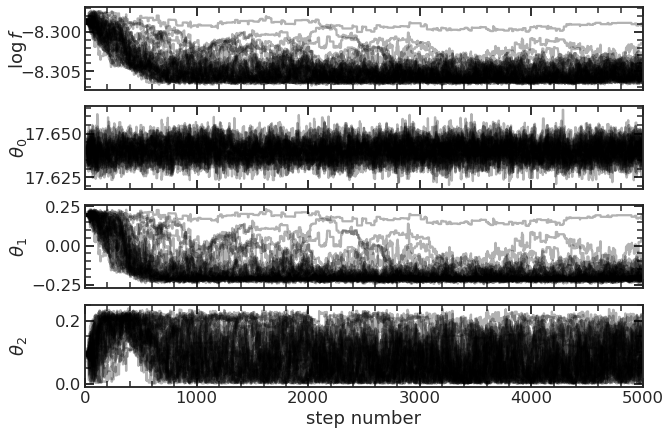

In [86]:
# fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = [r"$\log f$", r"$\theta_{0}$", r"$\theta_{1}$", r"$\theta_{2}$"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [87]:
# fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = [r"$\log f$", r"$\theta_{0}$"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [88]:
# from emcee.autocorr import AutocorrError

In [89]:
# try:
#     tau = sampler.get_autocorr_time()
# except AutocorrError as e:
#     print("Run longer!")
#     tau = sampler.get_autocorr_time(tol=0)
# print(tau)

Run longer!
[439.92486077  87.81338673 439.10663594 287.98887352]


In [90]:
# burnin = int(np.max(tau))
# flat_samples = sampler.get_chain(discard=burnin, thin=15, flat=True)
# print(flat_samples.shape)

(9728, 4)


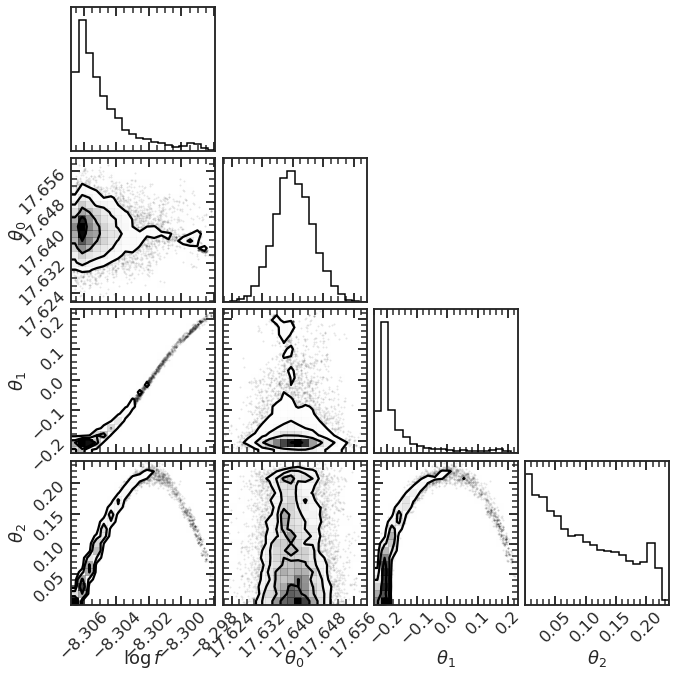

In [91]:
# import corner

# fig = corner.corner(
#     flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
# );

In [92]:
# from IPython.display import display, Math

# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Jackknife

That was bad, let's try something else.

In [102]:
# from tqdm import tqdm

In [103]:
# t_fit = np.linspace(qso_J1139_mjd.min(), qso_J1139_mjd.max())

# freq = [] / u.s
# th0 = [] * u.mag
# th1 = [] * u.mag
# th2 = [] * u.mag
# for i in tqdm(range(len(qso_J1139_mjd))):
#     t = np.delete(qso_J1139_mjd, i)
#     mag = np.delete(qso_J1139_mag, i)
#     magerr = np.delete(qso_J1139_magerr, i)
    
#     ls = LombScargle(t, mag, magerr)
    
#     frequencies, power = ls.autopower()
#     freq_i = frequencies[np.argmax(power)]
#     th0_i, th1_i, th2_i = ls.model_parameters(freq_i)
    
#     freq = np.append(freq, freq_i)
#     th0 = np.append(th0, th0_i)
#     th1 = np.append(th1, th1_i)
#     th2 = np.append(th2, th2_i)

100%|████████████████████████████████████████| 398/398 [00:02<00:00, 178.46it/s]


In [109]:
# params = np.array([np.log10(freq.value), th0, th1, th2]).T

# for i in range(ndim):
#     mcmc = np.percentile(params[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Bootstrap

In [104]:
# flat_samples.shape

(9728, 4)

(4, 398)